# Purpose

This notebook is to process the LastFM-1b dataset to extract the data we are interested in. Go to http://www.cp.jku.at/datasets/LFM-1b/ to download the dataset and extract LFM-1b.zip into rawData/LFM-1b

# Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os

In [2]:
import re
def DropAllNullColumns(data):
    columnsToDrop = []
    for column in data.columns:
        if data[column].isnull().values.all():
            columnsToDrop.append(column)

    print('Dropping all the following columns since all NaN values')
    print(columnsToDrop)
    data.drop(columnsToDrop, axis = 1, inplace = True)
    
def UpperCaseStringColumns(data):
    for column in data.columns:
        if (pd.api.types.infer_dtype(data[column]) == 'string'):
            print(column + ': Upper Casing')
            data[column] = data[column].str.upper()
            
def CompressIntegerColumns(data):
    for column in data.columns:
        if (np.issubdtype(data[column].dtype, np.integer)):       
            minValue = data[column].min()
            maxValue = data[column].max()
            
            info = np.iinfo
            if minValue >= 0:
                types = (np.uint8, np.uint16, np.uint32, np.uint64)
            else:
                types = (np.int8, np.int16, np.int32, np.int64)

            for t in types:
                if info(t).min <= minValue and maxValue <= info(t).max:
                    print(str(column) + ': Converting to ' + t.__name__)
                    data[column] = data[column].astype(t)
                    break
                
def ConvertFloatColumnsToIntegerIfNoDataLoss(data):
    for column in data.columns:
        try:
            if (np.issubdtype(data[column].dtype, np.float)):
                temp = data[column].astype(np.int64)

                if ((temp == data[column]).all()):
                    print(column + ': Converting to ' + str(temp.dtype))
                    data[column] = temp
        except:
            pass

def ConvertStringColumnsToInt(data):
    for column in data.columns:
        if (pd.api.types.infer_dtype(data[column]) == 'string'):
            if data[column].isnull().values.any():
                continue

            if (data[column].apply(lambda x: re.match('^[0-9,-]+$', x) != None).all()):
                print(column + ': Converting to int')
                data[column] = data[column].str.replace(',', '')
                data[column] = data[column].astype(np.int64) 

def ConvertStringColumnsToFloat(data):
    for column in data.columns:
        if (pd.api.types.infer_dtype(data[column]) == 'string'):
            if data[column].isnull().values.any():
                continue

            if (data[column].apply(lambda x: re.match('^[0-9,-\.]+$', x) != None).all()):
                print(column + ': Converting to float')
                data[column] = data[column].str.replace(',', '')
                data[column] = data[column].astype(np.float64)
                                
def InspectColumnValues(data):
    for column in data.columns:
        try:
            values = data[column].unique()
            print(column + ': ' + str(len(values)))
            print(values[0:10])
            print()
        except:
            print('Error with: ' + column)
            
def SaveData(data, name):
    data = data.reset_index(drop = True)
    data.columns = data.columns.str.replace('_', ' ').str.title()
    if (os.path.exists('../../data/') == False):
        os.makedirs('../../data/')
        
    data.to_parquet('../../data/' + name + '.gzip.parquet', compression = 'gzip')
    return pd.read_parquet('../../data/' + name + '.gzip.parquet')

##  Filtering Users for Ages 6 to 17

In [3]:
users = pd.read_csv('LFM-1b_users.txt', delimiter='\t')
users.columns = users.columns.str.replace('_', ' ').str.title()
users.info()
users.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120322 entries, 0 to 120321
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User Id              120322 non-null  int64 
 1   Country              55186 non-null   object
 2   Age                  120322 non-null  int64 
 3   Gender               120110 non-null  object
 4   Playcount            120322 non-null  int64 
 5   Registered Unixtime  120322 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 5.5+ MB


,User Id,Country,Age,Gender,Playcount,Registered Unixtime
0,384,UK,35,m,42139,1035849600
1,1206,NaN,-1,n,33103,1035849600
2,2622,NaN,-1,NaN,2030,1037404800
3,2732,NaN,-1,n,147,1037577600
4,3653,UK,31,m,18504,1041033600


In [4]:
users = users[(users['Age'] >= 6) & (users['Age'] <= 17)].copy()
users = users.fillna('Unknown')
CompressIntegerColumns(users)
UpperCaseStringColumns(users)
users['Country'] = users['Country'].astype('category')
users['Gender'] = users['Gender'].astype('category')
users.info()

User Id: Converting to uint32
Age: Converting to uint8
Playcount: Converting to int32
Registered Unixtime: Converting to uint32
Country: Upper Casing
Gender: Upper Casing
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3416 entries, 272 to 120321
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   User Id              3416 non-null   uint32  
 1   Country              3416 non-null   category
 2   Age                  3416 non-null   uint8   
 3   Gender               3416 non-null   category
 4   Playcount            3416 non-null   int32   
 5   Registered Unixtime  3416 non-null   uint32  
dtypes: category(2), int32(1), uint32(2), uint8(1)
memory usage: 81.7 KB


### Assigning the Age Group for users

In [5]:
def GetAgeGroup(age):
    if (age <= 11):
        return 'GS'
    if (age <= 14):
        return 'MS'
    return 'HS'

users['Education Level'] = users['Age'].apply(GetAgeGroup)
cat_type = pd.api.types.CategoricalDtype(categories=['GS', 'MS', 'HS'], ordered=True)
users['Education Level'] = users['Education Level'].astype(cat_type)

### Saving for later use

In [6]:
users = SaveData(users, 'LastFM1bKidUsers')
users.head(5)

,User Id,Country,Age,Gender,Playcount,Registered Unixtime,Education Level
0,2014225,UK,10,N,455549,1092322957,GS
1,2484832,US,6,M,108980,1118154189,GS
2,2635077,SE,11,N,138552,1124089582,GS
3,2921901,US,6,M,102709,1131691440,GS
4,3556768,US,14,N,26508,1144345049,MS


## Filtering User additional

In [7]:
usersAdditional = pd.read_csv('LFM-1b_users_additional.txt', delimiter='\t', na_values = ['?'])
usersAdditional.columns = usersAdditional.columns.str.replace('_', ' ').str.replace('-', ' ').str.title()
usersAdditional.info()
usersAdditional.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120322 entries, 0 to 120321
Data columns (total 43 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   User Id                       120322 non-null  int64  
 1   Novelty Artist Avg Month      120182 non-null  float64
 2   Novelty Artist Avg 6Months    120322 non-null  float64
 3   Novelty Artist Avg Year       112792 non-null  float64
 4   Mainstreaminess Avg Month     120322 non-null  float64
 5   Mainstreaminess Avg 6Months   101711 non-null  float64
 6   Mainstreaminess Avg Year      120322 non-null  float64
 7   Mainstreaminess Global        120322 non-null  float64
 8   Cnt Listeningevents           120322 non-null  int64  
 9   Cnt Distinct Tracks           120322 non-null  int64  
 10  Cnt Distinct Artists          120322 non-null  int64  
 11  Cnt Listeningevents Per Week  120322 non-null  float64
 12  Relative Le Per Weekday1      117920 non-nul

,User Id,Novelty Artist Avg Month,Novelty Artist Avg 6Months,Novelty Artist Avg Year,Mainstreaminess Avg Month,Mainstreaminess Avg 6Months,Mainstreaminess Avg Year,Mainstreaminess Global,Cnt Listeningevents,Cnt Distinct Tracks,...,Relative Le Per Hour14,Relative Le Per Hour15,Relative Le Per Hour16,Relative Le Per Hour17,Relative Le Per Hour18,Relative Le Per Hour19,Relative Le Per Hour20,Relative Le Per Hour21,Relative Le Per Hour22,Relative Le Per Hour23
0,384,0.276629,0.044439,0.309429,0.024655,0.367343,0.000000,0.124903,17198,3601,...,0.0279,0.0410,0.0811,0.1506,0.0377,0.0298,0.0132,0.0007,0.0001,0.0151
1,1206,0.437224,0.109671,0.513787,0.181991,0.391304,0.000000,0.343855,17967,10990,...,0.0016,0.0115,0.0276,0.0662,0.0790,0.0838,0.0995,0.1195,0.0968,0.0839
2,2622,0.604828,0.043923,0.698983,0.052310,0.780064,0.079669,0.245980,3939,3084,...,0.1320,0.0493,0.0317,0.0470,0.0658,0.1127,0.1112,0.0680,0.0437,0.0254
3,2732,0.756973,0.020071,0.882801,0.005092,0.886364,0.032614,0.077512,234,202,...,0.0598,0.0726,0.0171,0.0342,0.0769,0.1453,0.0470,0.0513,0.0085,0.0128
4,3653,0.380005,0.045207,0.424411,0.042821,0.491756,0.077731,0.207567,18238,9839,...,0.0541,0.0518,0.0564,0.0554,0.0849,0.0954,0.0833,0.0657,0.0471,0.0595


In [8]:
usersAdditional = usersAdditional[usersAdditional['User Id'].isin(users['User Id'])].copy()
ConvertFloatColumnsToIntegerIfNoDataLoss(usersAdditional)
CompressIntegerColumns(usersAdditional)
usersAdditional.info()

User Id: Converting to uint32
Cnt Listeningevents: Converting to uint32
Cnt Distinct Tracks: Converting to uint16
Cnt Distinct Artists: Converting to uint16
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3416 entries, 272 to 120321
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   User Id                       3416 non-null   uint32 
 1   Novelty Artist Avg Month      3407 non-null   float64
 2   Novelty Artist Avg 6Months    3416 non-null   float64
 3   Novelty Artist Avg Year       3199 non-null   float64
 4   Mainstreaminess Avg Month     3416 non-null   float64
 5   Mainstreaminess Avg 6Months   2896 non-null   float64
 6   Mainstreaminess Avg Year      3416 non-null   float64
 7   Mainstreaminess Global        3416 non-null   float64
 8   Cnt Listeningevents           3416 non-null   uint32 
 9   Cnt Distinct Tracks           3416 non-null   uint16 
 10  Cnt Distinct Artist

### Saving for later use

In [9]:
usersAdditional = SaveData(usersAdditional, 'LastFM1bKidUsersAdditional')
usersAdditional.head(5)

,User Id,Novelty Artist Avg Month,Novelty Artist Avg 6Months,Novelty Artist Avg Year,Mainstreaminess Avg Month,Mainstreaminess Avg 6Months,Mainstreaminess Avg Year,Mainstreaminess Global,Cnt Listeningevents,Cnt Distinct Tracks,...,Relative Le Per Hour14,Relative Le Per Hour15,Relative Le Per Hour16,Relative Le Per Hour17,Relative Le Per Hour18,Relative Le Per Hour19,Relative Le Per Hour20,Relative Le Per Hour21,Relative Le Per Hour22,Relative Le Per Hour23
0,2014225,0.578795,0.078465,0.873862,0.178763,0.873862,0.300738,0.346664,19875,10827,...,0.0447,0.0442,0.0393,0.0491,0.0481,0.0420,0.0397,0.0377,0.0491,0.0487
1,2484832,0.133756,0.059216,0.192178,0.134789,0.276256,0.129691,0.264266,18564,5933,...,0.0120,0.0130,0.0201,0.0389,0.0533,0.0609,0.0617,0.0608,0.0618,0.0650
2,2635077,0.298200,0.096281,0.444724,0.148655,0.571657,0.179526,0.463026,128904,36307,...,0.0809,0.0799,0.0802,0.0702,0.0629,0.0570,0.0327,0.0203,0.0184,0.0179
3,2921901,0.341162,0.036058,0.451412,0.106080,0.464148,0.047325,0.176432,19991,9145,...,NaN,0.0004,0.0005,0.0031,0.0162,0.0651,0.0927,0.0736,0.0735,0.0919
4,3556768,0.466205,0.024370,0.634754,0.077599,0.706226,0.059570,0.193772,18796,8478,...,0.0123,0.0188,0.0256,0.0309,0.0380,0.0429,0.0461,0.0521,0.0537,0.0513


## Filtering Listening Events

In [10]:
filtered = []
with pd.read_csv('LFM-1b_LEs.txt', delimiter='\t', header = None, chunksize = 10 ** 6, na_filter = False) as reader:
    for chunk in reader:
        filtered.append(chunk[chunk[0].isin(users['User Id'])])
        
listeningEvents = pd.concat(filtered)
listeningEvents = listeningEvents.rename(columns = {0: 'user id', 1: 'artist id', 2: 'album id', 3: 'track id', 4: 'event unixtime'})
listeningEvents.columns = listeningEvents.columns.str.replace('_', ' ').str.title()
listeningEvents.info()
listeningEvents.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37096515 entries, 374967 to 1088159375
Data columns (total 5 columns):
 #   Column          Dtype
---  ------          -----
 0   User Id         int64
 1   Artist Id       int64
 2   Album Id        int64
 3   Track Id        int64
 4   Event Unixtime  int64
dtypes: int64(5)
memory usage: 1.7 GB


,User Id,Artist Id,Album Id,Track Id,Event Unixtime
374967,15397460,15610,33142,99816,1391098195
374968,15397460,15611,33143,99817,1389629160
374969,15397460,3684,7907,99818,1386702226
374970,15397460,15428,33144,99819,1379626679
374971,15397460,11125,33145,99820,1377887882


In [11]:
CompressIntegerColumns(listeningEvents)
listeningEvents.info()

User Id: Converting to uint32
Artist Id: Converting to uint32
Album Id: Converting to uint32
Track Id: Converting to uint32
Event Unixtime: Converting to uint32
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37096515 entries, 374967 to 1088159375
Data columns (total 5 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   User Id         uint32
 1   Artist Id       uint32
 2   Album Id        uint32
 3   Track Id        uint32
 4   Event Unixtime  uint32
dtypes: uint32(5)
memory usage: 990.6 MB


### Adding Tracks

In [12]:
temp = pd.read_csv('LFM-1b_tracks.txt', delimiter='\t', header = None, quoting = 3, na_filter = False)
temp = temp.rename(columns = {0: 'track id', 1: 'track', 2: 'artist id'})
temp.columns = temp.columns.str.replace('_', ' ').str.title()
temp.info()
temp.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32291134 entries, 0 to 32291133
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Track Id   int64 
 1   Track      object
 2   Artist Id  int64 
dtypes: int64(2), object(1)
memory usage: 739.1+ MB


,Track Id,Track,Artist Id
0,1,A Matter of Time,3
1,2,Hangar 18,1
2,3,Up the Downstair,4
3,4,Mr. Carter (Featuring Jay-Z),2
4,5,Mixtaped,5


In [13]:
listeningEvents = listeningEvents.merge(temp, on = ['Artist Id', 'Track Id'], how = 'left')
listeningEvents.head(5)

,User Id,Artist Id,Album Id,Track Id,Event Unixtime,Track
0,15397460,15610,33142,99816,1391098195,Faith
1,15397460,15611,33143,99817,1389629160,Introduced Species
2,15397460,3684,7907,99818,1386702226,This Is What It Feels Like
3,15397460,15428,33144,99819,1379626679,Lights & Thunder Ft. Gareth Emery
4,15397460,11125,33145,99820,1377887882,Cry For Help


### Adding Album

In [14]:
temp = pd.read_csv('LFM-1b_albums.txt', delimiter='\t', header = None, quoting = 3, na_filter = False)
temp = temp.rename(columns = {0: 'album id', 1: 'album', 2: 'artist id'})
temp.columns = temp.columns.str.replace('_', ' ').str.title()
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15991038 entries, 0 to 15991037
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Album Id   int64 
 1   Album      object
 2   Artist Id  int64 
dtypes: int64(2), object(1)
memory usage: 366.0+ MB


In [15]:
listeningEvents = listeningEvents.merge(temp, on = ['Artist Id', 'Album Id'], how = 'left')
listeningEvents.head(5)

,User Id,Artist Id,Album Id,Track Id,Event Unixtime,Track,Album
0,15397460,15610,33142,99816,1391098195,Faith,Chiaroscuro
1,15397460,15611,33143,99817,1389629160,Introduced Species,Unimagine
2,15397460,3684,7907,99818,1386702226,This Is What It Feels Like,LONDON
3,15397460,15428,33144,99819,1379626679,Lights & Thunder Ft. Gareth Emery,Get Wet
4,15397460,11125,33145,99820,1377887882,Cry For Help,Addicts Black Meddle Pt II


### Adding Artists

In [16]:
temp = pd.read_csv('LFM-1b_artists.txt', delimiter='\t', header = None, quoting = 3, na_filter = False)
temp = temp.rename(columns = {0: 'artist id', 1: 'artist'})
temp.columns = temp.columns.str.replace('_', ' ').str.title()
temp.info()
temp.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3190371 entries, 0 to 3190370
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Artist Id  int64 
 1   Artist     object
dtypes: int64(1), object(1)
memory usage: 48.7+ MB


,Artist Id,Artist
0,1,Megadeth
1,2,Lil Wayne
2,3,Foo Fighters
3,4,Porcupine Tree
4,5,No-Man


In [17]:
listeningEvents = listeningEvents.merge(temp, on = 'Artist Id', how = 'left')
temp = None
listeningEvents.head(5)

,User Id,Artist Id,Album Id,Track Id,Event Unixtime,Track,Album,Artist
0,15397460,15610,33142,99816,1391098195,Faith,Chiaroscuro,I Break Horses
1,15397460,15611,33143,99817,1389629160,Introduced Species,Unimagine,Hands Like Houses
2,15397460,3684,7907,99818,1386702226,This Is What It Feels Like,LONDON,Banks
3,15397460,15428,33144,99819,1379626679,Lights & Thunder Ft. Gareth Emery,Get Wet,Krewella
4,15397460,11125,33145,99820,1377887882,Cry For Help,Addicts Black Meddle Pt II,Nachtmystium


In [18]:
UpperCaseStringColumns(listeningEvents)
listeningEvents['Track'] = listeningEvents['Track'].astype('category')
listeningEvents['Album'] = listeningEvents['Album'].astype('category')
listeningEvents['Artist'] = listeningEvents['Artist'].astype('category')
listeningEvents.info()

Track: Upper Casing
Album: Upper Casing
Artist: Upper Casing
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37096515 entries, 0 to 37096514
Data columns (total 8 columns):
 #   Column          Dtype   
---  ------          -----   
 0   User Id         uint32  
 1   Artist Id       uint32  
 2   Album Id        uint32  
 3   Track Id        uint32  
 4   Event Unixtime  uint32  
 5   Track           category
 6   Album           category
 7   Artist          category
dtypes: category(3), uint32(5)
memory usage: 1.5 GB


In [19]:
listeningEventsWithUsers = listeningEvents.merge(users, on = 'User Id', how = 'left')
listeningEventsWithUsers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37096515 entries, 0 to 37096514
Data columns (total 14 columns):
 #   Column               Dtype   
---  ------               -----   
 0   User Id              uint32  
 1   Artist Id            uint32  
 2   Album Id             uint32  
 3   Track Id             uint32  
 4   Event Unixtime       uint32  
 5   Track                category
 6   Album                category
 7   Artist               category
 8   Country              category
 9   Age                  uint8   
 10  Gender               category
 11  Playcount            int32   
 12  Registered Unixtime  uint32  
 13  Education Level      category
dtypes: category(6), int32(1), uint32(6), uint8(1)
memory usage: 1.9 GB


In [20]:
listeningEventsWithUsers = listeningEventsWithUsers[['Age', 'Education Level', 'Artist', 'Album', 'Track', 'User Id', 'Artist Id', 'Album Id', 'Track Id', 'Event Unixtime']]
listeningEventsWithUsers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37096515 entries, 0 to 37096514
Data columns (total 10 columns):
 #   Column           Dtype   
---  ------           -----   
 0   Age              uint8   
 1   Education Level  category
 2   Artist           category
 3   Album            category
 4   Track            category
 5   User Id          uint32  
 6   Artist Id        uint32  
 7   Album Id         uint32  
 8   Track Id         uint32  
 9   Event Unixtime   uint32  
dtypes: category(4), uint32(5), uint8(1)
memory usage: 1.6 GB


### Saving for later use

In [21]:
listeningEventsWithUsers['Partition'] = listeningEventsWithUsers.index % 10
listeningEventsWithUsers['Partition'] = listeningEventsWithUsers['Partition'].astype(np.uint8)
listeningEventsWithUsers.to_parquet('../../data/LastFM1bKidListeningEventsWithUsers', index = False, compression = 'gzip', partition_cols = ['Partition'])
listeningEventsWithUsers = pd.read_parquet('../../data/LastFM1bKidListeningEventsWithUsers')
listeningEventsWithUsers.head(5)

,Age,Education Level,Artist,Album,Track,User Id,Artist Id,Album Id,Track Id,Event Unixtime,Partition
0,16,HS,I BREAK HORSES,CHIAROSCURO,FAITH,15397460,15610,33142,99816,1391098195,0
1,16,HS,TAYLOR SWIFT,FEARLESS,FEARLESS,15397460,3744,30727,99833,1374858428,0
2,16,HS,HIM,TEARS ON TAPE,W.L.S.T.D.,15397460,10028,33156,99851,1369547268,0
3,16,HS,AMARANTHE,THE NEXUS,INFINITY,15397460,104,33147,99875,1365511561,0
4,16,HS,AMARANTHE,THE NEXUS,INVINCIBLE,15397460,104,33147,99823,1365509450,0


## Basic Analysis Report

### Users

In [22]:
users.describe()

,User Id,Age,Playcount,Registered Unixtime
count,3.416000e+03,3416.000000,3416.000000,3.416000e+03
mean,3.808298e+07,16.004098,14898.789813,1.300058e+09
std,1.129596e+07,1.495914,26169.239837,3.592372e+07
min,2.014225e+06,6.000000,-1.000000,1.092323e+09
25%,3.167754e+07,16.000000,1073.750000,1.280580e+09
50%,4.070294e+07,16.000000,4371.000000,1.310498e+09
75%,4.805681e+07,17.000000,19310.750000,1.329483e+09
max,5.096744e+07,17.000000,455549.000000,1.343251e+09


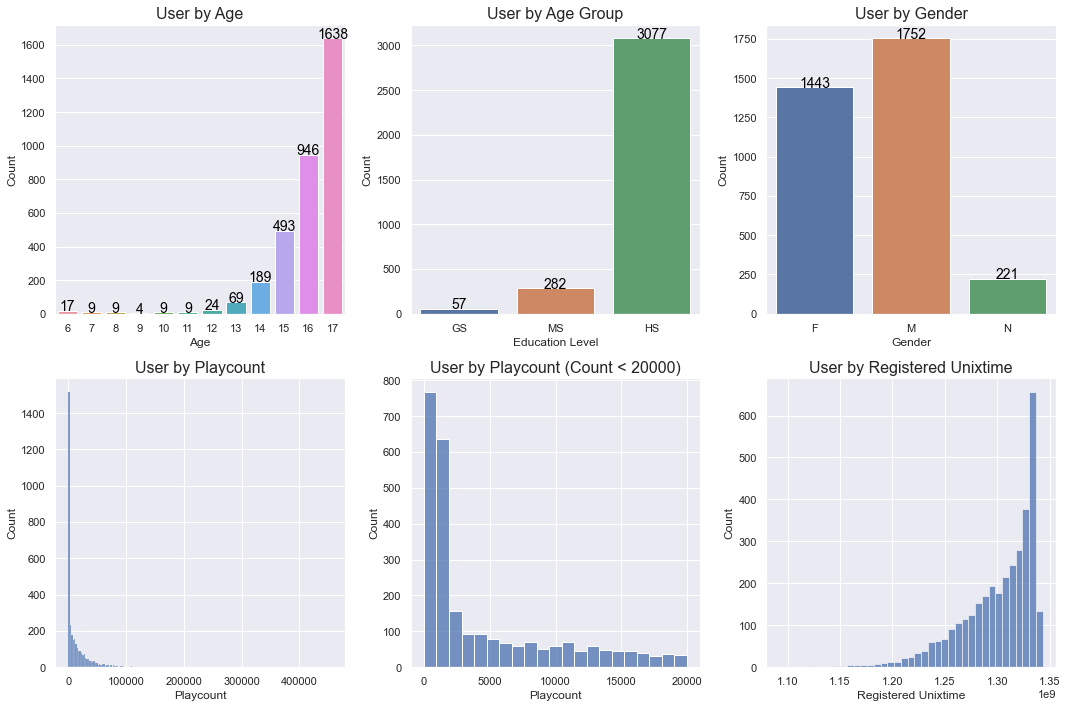

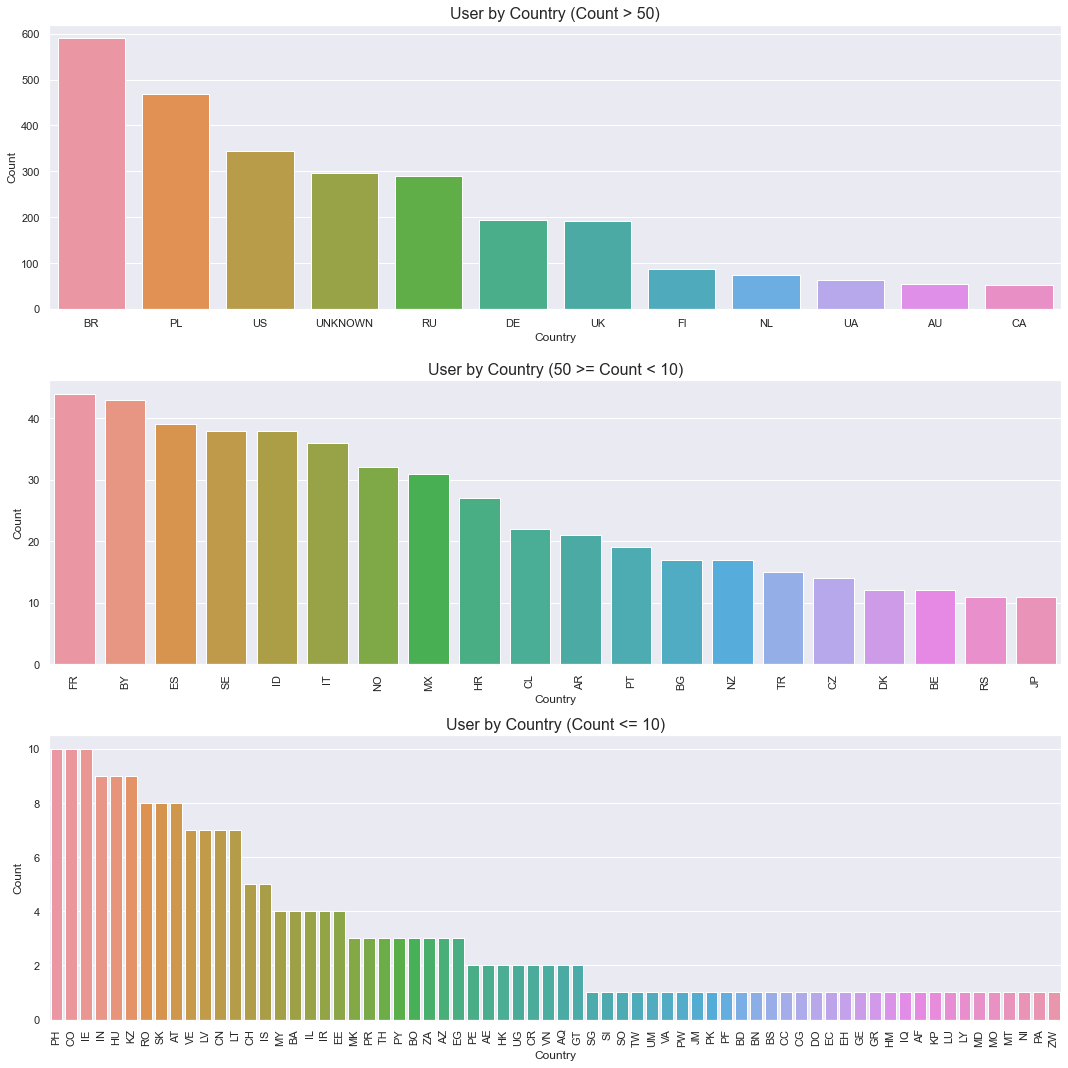

In [23]:
sns.set(font_scale=1)

fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize=(15, 10))

groupedValues = users.groupby(by = 'Age').count().reset_index()
groupedValues['Count'] = groupedValues['User Id']
g = sns.barplot(data = groupedValues, x = 'Age', y = 'Count', ax = axs[0][0])
for index, row in groupedValues.iterrows():
    g.text(index, row['Count'], int(row['Count']), color='black', ha="center", fontsize = 14)
g.axes.set_title('User by Age', fontsize = 16)
    
groupedValues = users.groupby(by = 'Education Level').count().reset_index()
groupedValues['Count'] = groupedValues['User Id']
g = sns.barplot(data = groupedValues, x = 'Education Level', y = 'Count', ax = axs[0][1])
for index, row in groupedValues.iterrows():
    g.text(index, row['Count'], int(row['Count']), color='black', ha="center", fontsize = 14)
g.axes.set_title('User by Age Group', fontsize = 16)
    
groupedValues = users.groupby(by = 'Gender').count().reset_index()
groupedValues['Count'] = groupedValues['User Id']
g = sns.barplot(data = groupedValues, x = 'Gender', y = 'Count', ax = axs[0][2])
for index, row in groupedValues.iterrows():
    g.text(index, row['Count'], int(row['Count']), color='black', ha="center", fontsize = 14)
g.axes.set_title('User by Gender', fontsize = 16)
    
g = sns.histplot(data = users['Playcount'], ax = axs[1][0])
g.axes.set_title('User by Playcount', fontsize = 16)

g = sns.histplot(data = users[users['Playcount'] < 20000]['Playcount'], ax = axs[1][1])
g.axes.set_title('User by Playcount (Count < 20000)', fontsize = 16)

g = sns.histplot(data = users['Registered Unixtime'], ax = axs[1][2])
g.axes.set_title('User by Registered Unixtime', fontsize = 16)

plt.tight_layout()
plt.show()

temp = users.groupby(by = 'Country').count()['User Id'].reset_index().rename(columns = {'User Id': 'Count'}).sort_values(['Count'], ascending = False)
temp['Country'] = temp['Country'].astype(str)
fig, axs = plt.subplots(nrows = 3, figsize=(15, 15))
g = sns.barplot(data = temp[temp['Count'] > 50], x = 'Country', y = 'Count', ax = axs[0])
g.axes.set_title('User by Country (Count > 50)', fontsize = 16)

g = sns.barplot(data = temp[(temp['Count'] <= 50) & (temp['Count'] > 10)], x = 'Country', y = 'Count', ax = axs[1])
g.axes.set_title('User by Country (50 >= Count < 10)', fontsize = 16)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

g = sns.barplot(data = temp[temp['Count'] <= 10], x = 'Country', y = 'Count', ax = axs[2])
g.axes.set_title('User by Country (Count <= 10)', fontsize = 16)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show();

### Listening Events

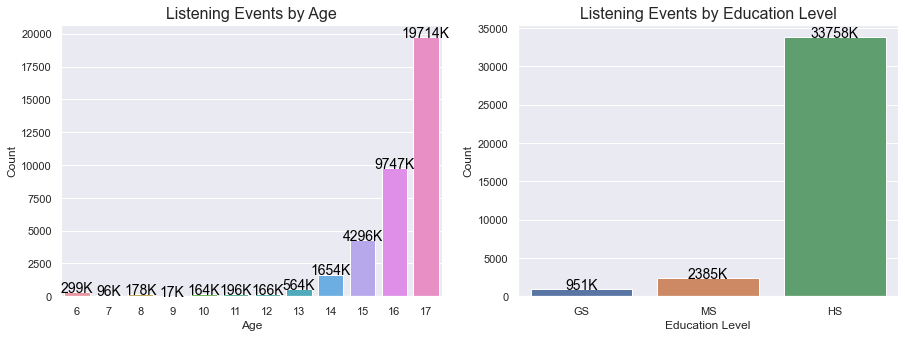

In [24]:
fig, axs = plt.subplots(ncols = 2, figsize=(15, 5))

groupedValues = listeningEventsWithUsers.groupby(by = 'Age').count().reset_index()
groupedValues['Count'] = groupedValues['User Id'] / 1000
g = sns.barplot(data = groupedValues, x = 'Age', y = 'Count', ax = axs[0])
for index, row in groupedValues.iterrows():
    g.text(index, row['Count'], str(int(row['Count'])) + 'K', color='black', ha="center", fontsize = 14)
g.axes.set_title('Listening Events by Age', fontsize = 16)
    
groupedValues = listeningEventsWithUsers.groupby(by = 'Education Level').count().reset_index()
groupedValues['Count'] = groupedValues['User Id'] / 1000
g = sns.barplot(data = groupedValues, x = 'Education Level', y = 'Count', ax = axs[1])
for index, row in groupedValues.iterrows():
    g.text(index, row['Count'], str(int(row['Count'])) + 'K', color='black', ha="center", fontsize = 14)
g.axes.set_title('Listening Events by Education Level', fontsize = 16)

plt.show();

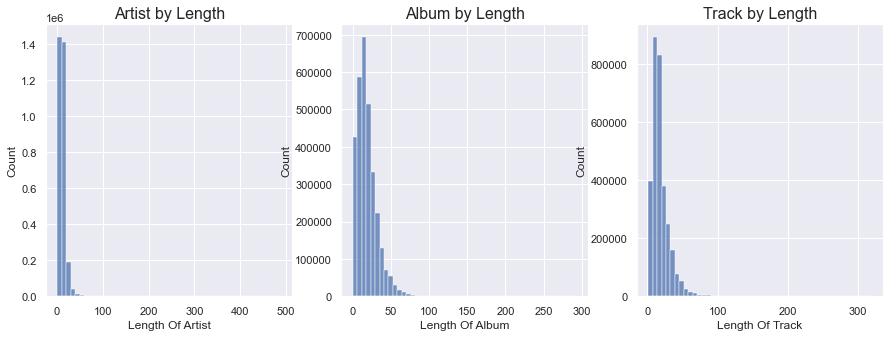

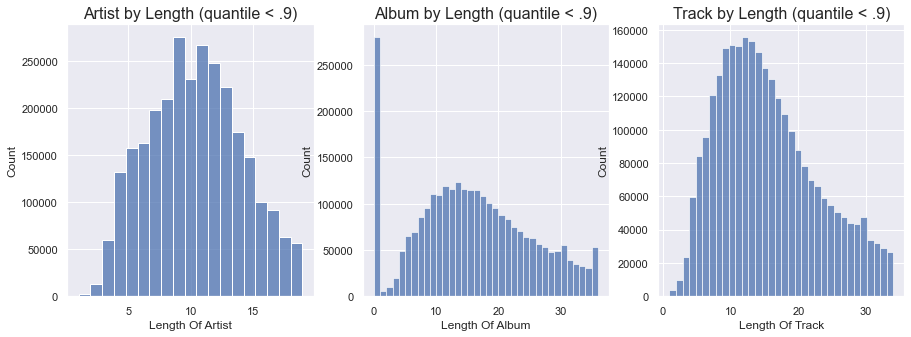

In [25]:
temp = listeningEventsWithUsers[['Artist', 'Album', 'Track']].drop_duplicates()
temp['Length Of Artist'] = temp['Artist'].apply(lambda x: len(x))
temp['Length Of Album'] = temp['Album'].apply(lambda x: len(x))
temp['Length Of Track'] = temp['Track'].apply(lambda x: len(x))

fig, axs = plt.subplots(ncols = 3, figsize=(15, 5))

g = sns.histplot(data = temp['Length Of Artist'], ax = axs[0], bins = 50)
g.axes.set_title('Artist by Length', fontsize = 16)

g = sns.histplot(data = temp['Length Of Album'], ax = axs[1], bins = 50)
g.axes.set_title('Album by Length', fontsize = 16)

g = sns.histplot(data = temp['Length Of Track'], ax = axs[2], bins = 50)
g.axes.set_title('Track by Length', fontsize = 16)

plt.show()

fig, axs = plt.subplots(ncols = 3, figsize=(15, 5))

quantile = int(np.quantile(temp['Length Of Artist'], q = .9))
g = sns.histplot(data = temp[temp['Length Of Artist'] <= quantile]['Length Of Artist'], ax = axs[0], bins = quantile)
g.axes.set_title('Artist by Length (quantile < .9)', fontsize = 16)

quantile = int(np.quantile(temp['Length Of Album'], q = .9))
g = sns.histplot(data = temp[temp['Length Of Album'] <= quantile]['Length Of Album'], ax = axs[1], bins = quantile)
g.axes.set_title('Album by Length (quantile < .9)', fontsize = 16)

quantile = int(np.quantile(temp['Length Of Track'], q = .9))
g = sns.histplot(data = temp[temp['Length Of Track'] <= quantile]['Length Of Track'], ax = axs[2], bins = quantile)
g.axes.set_title('Track by Length (quantile < .9)', fontsize = 16)

plt.show()

There's some bad data in the Artist, Album and Track fields since no name should be longer than 50+ characters.

Also with Album length of zero, when merging with Spotify should only use Artist and Track